# Import Libraries and Load New Dataset

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split


# Load data
train = pd.read_csv('../data/new_train.csv')
print("Shape of train:", train.shape)
train.head()
print(list(train.columns))

Shape of train: (1460, 203)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LandContour_HLS', 'LandCon

# Select Features

In [2]:
# Load data
train = pd.read_csv('../data/new_train.csv')

# Drop 'Id' if present
if 'Id' in train.columns:
    train.drop(columns=['Id'], inplace=True)

# Separate target and features
y = train['SalePrice']
X = train.drop(columns=['SalePrice'])

# Pearson Correlation for Numerical Features
correlation_threshold = 0.2
correlation_matrix = X.corrwith(y)
num_high_corr_features = correlation_matrix[abs(correlation_matrix) > correlation_threshold].index.tolist()

# Keep only highly correlated features
selected_features = list(set(num_high_corr_features))

# Update X to include only selected features
X = X[selected_features]

# Split into Train (80%) and Dev (20%)
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

# Train initial XGBoost model
initial_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
initial_xgb_model.fit(X_train, y_train)

# Get Feature Importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': initial_xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Keep the top 40 features
top_features = feature_importances.head(40)['Feature'].tolist()

# Recursive Feature Elimination (RFE) to Further Reduce Features
rfe_selector = RFE(estimator=initial_xgb_model, n_features_to_select=30, step=1)
rfe_selector.fit(X_train[top_features], y_train)

rfe_selected_features = [feature for feature, selected in zip(top_features, rfe_selector.support_) if selected]

# Filter X_train and X_dev to only RFE-selected features
X_train_rfe = X_train[rfe_selected_features]
X_dev_rfe = X_dev[rfe_selected_features]

# Re-train XGBoost model with RFE-selected features
final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
final_xgb_model.fit(X_train_rfe, y_train)

# Print Feature Mismatch Before SHAP
print("\n--- Feature Debugging Before SHAP ---")
print("Train Features (X_train):", list(X_train_rfe.columns))
print("Dev Features (X_dev):", list(X_dev_rfe.columns))
print("RFE Selected Features:", rfe_selected_features)


# Convert all boolean columns to integers
X_dev_rfe = X_dev_rfe.astype({col: int for col in X_dev_rfe.select_dtypes(include='bool').columns})

# SHAP Analysis - Ensure exact feature alignment
explainer = shap.Explainer(lambda x: final_xgb_model.predict(pd.DataFrame(x, columns=X_dev_rfe.columns)), X_dev_rfe, algorithm="permutation")
shap_values = explainer(X_dev_rfe)

# Calculate SHAP importance
shap_importance = pd.DataFrame({'Feature': rfe_selected_features, 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

# Keep the top 25 most influential features based on SHAP
final_selected_features = shap_importance.head(25)['Feature'].tolist()

# Evaluate Final Model
y_pred_final = final_xgb_model.predict(X_dev_rfe)
final_rmse = root_mean_squared_error(y_dev, y_pred_final)

print(f"\nFinal RMSE: {final_rmse}")
print("Final Selected Features:", final_selected_features)



--- Feature Debugging Before SHAP ---
Train Features (X_train): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'HouseAge', 'TotalBsmtSF', 'GarageFinish', 'MSZoning_RM', 'KitchenQual', 'BsmtFinSF1', 'YearBuilt', 'Fireplaces', 'MSZoning_RL', '2ndFlrSF', '1stFlrSF', 'lot_frontage_lot_area', 'TotalBath', 'BsmtFinType1', 'CentralAir', 'GarageQual', 'ExterQual', 'RemodAge', 'YearRemodAdd', 'SaleType_New', 'LotArea', 'GrLivArea', 'FireplaceQu', 'BsmtExposure', 'GarageCond']
Dev Features (X_dev): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'HouseAge', 'TotalBsmtSF', 'GarageFinish', 'MSZoning_RM', 'KitchenQual', 'BsmtFinSF1', 'YearBuilt', 'Fireplaces', 'MSZoning_RL', '2ndFlrSF', '1stFlrSF', 'lot_frontage_lot_area', 'TotalBath', 'BsmtFinType1', 'CentralAir', 'GarageQual', 'ExterQual', 'RemodAge', 'YearRemodAdd', 'SaleType_New', 'LotArea', 'GrLivArea', 'FireplaceQu', 'BsmtExposure', 'GarageCond']
RFE Selected Features: ['Qual

PermutationExplainer explainer:   1%|▋                                                                                                         | 2/292 [00:00<?, ?it/s]

PermutationExplainer explainer:   2%|█▋                                                                                                | 5/292 [00:10<00:17, 16.58it/s]

PermutationExplainer explainer:   2%|██▎                                                                                               | 7/292 [00:10<00:16, 17.28it/s]

PermutationExplainer explainer:   3%|███                                                                                               | 9/292 [00:10<00:17, 16.27it/s]

PermutationExplainer explainer:   4%|███▉                                                                                             | 12/292 [00:10<00:14, 18.69it/s]

PermutationExplainer explainer:   5%|████▉                                                                                            | 15/292 [00:10<00:13, 20.37it/s]

PermutationExplainer explainer:   6%|█████▉                                                                                           | 18/292 [00:10<00:13, 20.83it/s]

PermutationExplainer explainer:   7%|██████▉                                                                                          | 21/292 [00:11<00:12, 21.39it/s]

PermutationExplainer explainer:   8%|███████▉                                                                                         | 24/292 [00:11<00:12, 22.02it/s]

PermutationExplainer explainer:   9%|████████▉                                                                                        | 27/292 [00:11<00:12, 21.77it/s]

PermutationExplainer explainer:  10%|█████████▉                                                                                       | 30/292 [00:11<00:12, 20.50it/s]

PermutationExplainer explainer:  11%|██████████▉                                                                                      | 33/292 [00:11<00:12, 20.96it/s]

PermutationExplainer explainer:  12%|███████████▉                                                                                     | 36/292 [00:11<00:12, 20.82it/s]

PermutationExplainer explainer:  13%|████████████▉                                                                                    | 39/292 [00:11<00:12, 20.77it/s]

PermutationExplainer explainer:  14%|█████████████▉                                                                                   | 42/292 [00:11<00:11, 21.12it/s]

PermutationExplainer explainer:  15%|██████████████▉                                                                                  | 45/292 [00:12<00:11, 20.88it/s]

PermutationExplainer explainer:  16%|███████████████▉                                                                                 | 48/292 [00:12<00:11, 21.02it/s]

PermutationExplainer explainer:  17%|████████████████▉                                                                                | 51/292 [00:12<00:11, 20.13it/s]

PermutationExplainer explainer:  18%|█████████████████▉                                                                               | 54/292 [00:12<00:11, 19.94it/s]

PermutationExplainer explainer:  20%|██████████████████▉                                                                              | 57/292 [00:12<00:12, 19.05it/s]

PermutationExplainer explainer:  20%|███████████████████▌                                                                             | 59/292 [00:12<00:12, 19.20it/s]

PermutationExplainer explainer:  21%|████████████████████▎                                                                            | 61/292 [00:12<00:12, 19.14it/s]

PermutationExplainer explainer:  22%|█████████████████████▎                                                                           | 64/292 [00:13<00:12, 18.74it/s]

PermutationExplainer explainer:  23%|█████████████████████▉                                                                           | 66/292 [00:13<00:11, 18.84it/s]

PermutationExplainer explainer:  23%|██████████████████████▌                                                                          | 68/292 [00:13<00:12, 18.62it/s]

PermutationExplainer explainer:  24%|███████████████████████▎                                                                         | 70/292 [00:13<00:13, 17.01it/s]

PermutationExplainer explainer:  25%|████████████████████████▎                                                                        | 73/292 [00:13<00:11, 18.85it/s]

PermutationExplainer explainer:  26%|█████████████████████████▏                                                                       | 76/292 [00:13<00:11, 19.60it/s]

PermutationExplainer explainer:  27%|█████████████████████████▉                                                                       | 78/292 [00:13<00:11, 19.28it/s]

PermutationExplainer explainer:  28%|██████████████████████████▉                                                                      | 81/292 [00:14<00:10, 20.50it/s]

PermutationExplainer explainer:  29%|███████████████████████████▉                                                                     | 84/292 [00:14<00:10, 20.73it/s]

PermutationExplainer explainer:  30%|████████████████████████████▉                                                                    | 87/292 [00:14<00:09, 20.59it/s]

PermutationExplainer explainer:  31%|█████████████████████████████▉                                                                   | 90/292 [00:14<00:10, 19.37it/s]

PermutationExplainer explainer:  32%|██████████████████████████████▉                                                                  | 93/292 [00:14<00:09, 20.20it/s]

PermutationExplainer explainer:  33%|███████████████████████████████▉                                                                 | 96/292 [00:14<00:10, 18.97it/s]

PermutationExplainer explainer:  34%|████████████████████████████████▉                                                                | 99/292 [00:14<00:09, 19.54it/s]

PermutationExplainer explainer:  35%|█████████████████████████████████▌                                                              | 102/292 [00:15<00:09, 20.59it/s]

PermutationExplainer explainer:  36%|██████████████████████████████████▌                                                             | 105/292 [00:15<00:09, 20.01it/s]

PermutationExplainer explainer:  37%|███████████████████████████████████▌                                                            | 108/292 [00:15<00:10, 17.61it/s]

PermutationExplainer explainer:  38%|████████████████████████████████████▍                                                           | 111/292 [00:15<00:09, 18.67it/s]

PermutationExplainer explainer:  39%|█████████████████████████████████████▏                                                          | 113/292 [00:15<00:09, 18.89it/s]

PermutationExplainer explainer:  39%|█████████████████████████████████████▊                                                          | 115/292 [00:15<00:10, 17.63it/s]

PermutationExplainer explainer:  40%|██████████████████████████████████████▊                                                         | 118/292 [00:15<00:09, 19.03it/s]

PermutationExplainer explainer:  41%|███████████████████████████████████████▍                                                        | 120/292 [00:16<00:09, 19.00it/s]

PermutationExplainer explainer:  42%|████████████████████████████████████████▍                                                       | 123/292 [00:16<00:08, 19.37it/s]

PermutationExplainer explainer:  43%|█████████████████████████████████████████▍                                                      | 126/292 [00:16<00:08, 20.62it/s]

PermutationExplainer explainer:  44%|██████████████████████████████████████████▍                                                     | 129/292 [00:16<00:07, 20.71it/s]

PermutationExplainer explainer:  45%|███████████████████████████████████████████▍                                                    | 132/292 [00:16<00:07, 20.18it/s]

PermutationExplainer explainer:  46%|████████████████████████████████████████████▍                                                   | 135/292 [00:16<00:08, 19.58it/s]

PermutationExplainer explainer:  47%|█████████████████████████████████████████████▎                                                  | 138/292 [00:16<00:07, 20.05it/s]

PermutationExplainer explainer:  48%|██████████████████████████████████████████████▎                                                 | 141/292 [00:17<00:07, 20.81it/s]

PermutationExplainer explainer:  49%|███████████████████████████████████████████████▎                                                | 144/292 [00:17<00:06, 21.48it/s]

PermutationExplainer explainer:  50%|████████████████████████████████████████████████▎                                               | 147/292 [00:17<00:06, 20.90it/s]

PermutationExplainer explainer:  51%|█████████████████████████████████████████████████▎                                              | 150/292 [00:17<00:06, 20.64it/s]

PermutationExplainer explainer:  52%|██████████████████████████████████████████████████▎                                             | 153/292 [00:17<00:06, 20.98it/s]

PermutationExplainer explainer:  53%|███████████████████████████████████████████████████▎                                            | 156/292 [00:17<00:06, 21.00it/s]

PermutationExplainer explainer:  54%|████████████████████████████████████████████████████▎                                           | 159/292 [00:18<00:07, 17.02it/s]

PermutationExplainer explainer:  55%|████████████████████████████████████████████████████▉                                           | 161/292 [00:18<00:08, 15.35it/s]

PermutationExplainer explainer:  56%|█████████████████████████████████████████████████████▉                                          | 164/292 [00:18<00:07, 16.13it/s]

PermutationExplainer explainer:  57%|██████████████████████████████████████████████████████▉                                         | 167/292 [00:18<00:07, 16.76it/s]

PermutationExplainer explainer:  58%|███████████████████████████████████████████████████████▌                                        | 169/292 [00:18<00:07, 15.85it/s]

PermutationExplainer explainer:  59%|████████████████████████████████████████████████████████▌                                       | 172/292 [00:18<00:07, 16.73it/s]

PermutationExplainer explainer:  60%|█████████████████████████████████████████████████████████▏                                      | 174/292 [00:18<00:07, 16.81it/s]

PermutationExplainer explainer:  60%|█████████████████████████████████████████████████████████▊                                      | 176/292 [00:19<00:08, 14.31it/s]

PermutationExplainer explainer:  61%|██████████████████████████████████████████████████████████▌                                     | 178/292 [00:19<00:09, 12.03it/s]

PermutationExplainer explainer:  62%|███████████████████████████████████████████████████████████▏                                    | 180/292 [00:19<00:10, 11.12it/s]

PermutationExplainer explainer:  62%|███████████████████████████████████████████████████████████▊                                    | 182/292 [00:19<00:09, 11.81it/s]

PermutationExplainer explainer:  63%|████████████████████████████████████████████████████████████▍                                   | 184/292 [00:19<00:08, 13.02it/s]

PermutationExplainer explainer:  64%|█████████████████████████████████████████████████████████████▏                                  | 186/292 [00:19<00:07, 14.27it/s]

PermutationExplainer explainer:  64%|█████████████████████████████████████████████████████████████▊                                  | 188/292 [00:20<00:06, 15.20it/s]

PermutationExplainer explainer:  65%|██████████████████████████████████████████████████████████████▍                                 | 190/292 [00:20<00:06, 16.17it/s]

PermutationExplainer explainer:  66%|███████████████████████████████████████████████████████████████▍                                | 193/292 [00:20<00:05, 17.93it/s]

PermutationExplainer explainer:  67%|████████████████████████████████████████████████████████████████▍                               | 196/292 [00:20<00:05, 18.59it/s]

PermutationExplainer explainer:  68%|█████████████████████████████████████████████████████████████████                               | 198/292 [00:20<00:05, 17.20it/s]

PermutationExplainer explainer:  68%|█████████████████████████████████████████████████████████████████▊                              | 200/292 [00:20<00:05, 16.38it/s]

PermutationExplainer explainer:  69%|██████████████████████████████████████████████████████████████████▍                             | 202/292 [00:20<00:05, 15.69it/s]

PermutationExplainer explainer:  70%|███████████████████████████████████████████████████████████████████                             | 204/292 [00:21<00:05, 15.88it/s]

PermutationExplainer explainer:  71%|███████████████████████████████████████████████████████████████████▋                            | 206/292 [00:21<00:05, 15.72it/s]

PermutationExplainer explainer:  71%|████████████████████████████████████████████████████████████████████▍                           | 208/292 [00:21<00:05, 15.70it/s]

PermutationExplainer explainer:  72%|█████████████████████████████████████████████████████████████████████                           | 210/292 [00:21<00:05, 14.78it/s]

PermutationExplainer explainer:  73%|█████████████████████████████████████████████████████████████████████▋                          | 212/292 [00:21<00:06, 12.77it/s]

PermutationExplainer explainer:  73%|██████████████████████████████████████████████████████████████████████▎                         | 214/292 [00:21<00:06, 11.32it/s]

PermutationExplainer explainer:  74%|███████████████████████████████████████████████████████████████████████                         | 216/292 [00:22<00:06, 11.54it/s]

PermutationExplainer explainer:  75%|███████████████████████████████████████████████████████████████████████▋                        | 218/292 [00:22<00:05, 13.09it/s]

PermutationExplainer explainer:  76%|████████████████████████████████████████████████████████████████████████▋                       | 221/292 [00:22<00:04, 16.25it/s]

PermutationExplainer explainer:  76%|█████████████████████████████████████████████████████████████████████████▎                      | 223/292 [00:22<00:04, 16.85it/s]

PermutationExplainer explainer:  77%|██████████████████████████████████████████████████████████████████████████▎                     | 226/292 [00:22<00:03, 18.81it/s]

PermutationExplainer explainer:  78%|███████████████████████████████████████████████████████████████████████████▎                    | 229/292 [00:22<00:03, 19.89it/s]

PermutationExplainer explainer:  79%|████████████████████████████████████████████████████████████████████████████▎                   | 232/292 [00:22<00:02, 21.11it/s]

PermutationExplainer explainer:  80%|█████████████████████████████████████████████████████████████████████████████▎                  | 235/292 [00:22<00:02, 22.05it/s]

PermutationExplainer explainer:  82%|██████████████████████████████████████████████████████████████████████████████▏                 | 238/292 [00:23<00:02, 22.48it/s]

PermutationExplainer explainer:  83%|███████████████████████████████████████████████████████████████████████████████▏                | 241/292 [00:23<00:02, 23.68it/s]

PermutationExplainer explainer:  84%|████████████████████████████████████████████████████████████████████████████████▏               | 244/292 [00:23<00:02, 22.70it/s]

PermutationExplainer explainer:  85%|█████████████████████████████████████████████████████████████████████████████████▏              | 247/292 [00:23<00:02, 20.70it/s]

PermutationExplainer explainer:  86%|██████████████████████████████████████████████████████████████████████████████████▏             | 250/292 [00:23<00:01, 21.74it/s]

PermutationExplainer explainer:  87%|███████████████████████████████████████████████████████████████████████████████████▏            | 253/292 [00:23<00:02, 19.24it/s]

PermutationExplainer explainer:  88%|████████████████████████████████████████████████████████████████████████████████████▏           | 256/292 [00:23<00:01, 19.54it/s]

PermutationExplainer explainer:  89%|█████████████████████████████████████████████████████████████████████████████████████▏          | 259/292 [00:24<00:01, 20.05it/s]

PermutationExplainer explainer:  90%|██████████████████████████████████████████████████████████████████████████████████████▏         | 262/292 [00:24<00:01, 16.16it/s]

PermutationExplainer explainer:  91%|███████████████████████████████████████████████████████████████████████████████████████         | 265/292 [00:24<00:01, 17.71it/s]

PermutationExplainer explainer:  91%|███████████████████████████████████████████████████████████████████████████████████████▊        | 267/292 [00:24<00:01, 17.26it/s]

PermutationExplainer explainer:  92%|████████████████████████████████████████████████████████████████████████████████████████▊       | 270/292 [00:24<00:01, 18.32it/s]

PermutationExplainer explainer:  93%|█████████████████████████████████████████████████████████████████████████████████████████▊      | 273/292 [00:24<00:00, 19.95it/s]

PermutationExplainer explainer:  95%|██████████████████████████████████████████████████████████████████████████████████████████▋     | 276/292 [00:24<00:00, 20.33it/s]

PermutationExplainer explainer:  96%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 279/292 [00:25<00:00, 17.13it/s]

PermutationExplainer explainer:  96%|████████████████████████████████████████████████████████████████████████████████████████████▍   | 281/292 [00:25<00:00, 16.73it/s]

PermutationExplainer explainer:  97%|█████████████████████████████████████████████████████████████████████████████████████████████   | 283/292 [00:25<00:00, 14.84it/s]

PermutationExplainer explainer:  98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 285/292 [00:25<00:00, 14.46it/s]

PermutationExplainer explainer:  98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 287/292 [00:25<00:00, 14.50it/s]

PermutationExplainer explainer:  99%|███████████████████████████████████████████████████████████████████████████████████████████████ | 289/292 [00:25<00:00, 14.20it/s]

PermutationExplainer explainer: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 291/292 [00:26<00:00, 14.86it/s]

PermutationExplainer explainer: 293it [00:26, 15.53it/s]                                                                                                               

PermutationExplainer explainer: 293it [00:26, 11.11it/s]


Final RMSE: 28327.55078125
Final Selected Features: ['Qual_LivArea_Interaction', 'TotalSF', 'BsmtFinSF1', 'OverallQual', 'TotalBsmtSF', 'HouseAge', 'KitchenQual', 'GarageCars', 'LotArea', 'RemodAge', 'TotalBath', 'GarageFinish', 'YearBuilt', 'BsmtFinType1', 'YearRemodAdd', 'FireplaceQu', 'BsmtQual', 'BsmtExposure', 'lot_frontage_lot_area', 'ExterQual', 'Fireplaces', 'MSZoning_RM', '1stFlrSF', 'GrLivArea', '2ndFlrSF']


# Try New Features

In [3]:
selected_features = ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd']
target = "SalePrice"

all_cols_needed = selected_features + [target]
df = train[all_cols_needed].copy()

print("Columns in use:\n", df.columns.tolist())
df.head()


Columns in use:
 ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd', 'SalePrice']


,Qual_LivArea_Interaction,TotalSF,TotalBsmtSF,BsmtFinSF1,RemodAge,OverallQual,KitchenQual,BsmtQual,YearBuilt,GarageCars,...,MSZoning_RL,BsmtFullBath,1stFlrSF,HouseAge,Neighborhood_Crawfor,CentralAir,KitchenAbvGr,Neighborhood_OldTown,TotRmsAbvGrd,SalePrice
0,11970,2566,856,706,5,7,3,4,2003,2,...,True,1,856,5,False,1,1,False,8,208500
1,7572,2524,1262,978,31,6,2,4,1976,2,...,True,0,1262,31,False,1,1,False,6,181500
2,12502,2706,920,486,6,7,3,4,2001,2,...,True,1,920,7,False,1,1,False,6,223500
3,12019,2473,756,216,36,7,3,3,1915,3,...,True,1,961,91,True,1,1,False,7,140000
4,17584,3343,1145,655,8,8,3,4,2000,3,...,True,1,1145,8,False,1,1,False,9,250000


# Define features and target

In [4]:
X = df[selected_features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1460, 30)
y shape: (1460,)


# Split Train and Dev Set

In [5]:
X_train, X_dev, y_train, y_dev = train_test_split(
    X, y, test_size=0.2, random_state=36
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Dev shapes:", X_dev.shape, y_dev.shape)


Train shapes: (1168, 30) (1168,)
Dev shapes: (292, 30) (292,)


# Train XGBoost

In [6]:
model = XGBRegressor(
    n_estimators=180,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10,
    reg_lambda=10,
    gamma=5,
    random_state=36,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_dev, y_dev)],
    verbose=10
)

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
dev_rmse = root_mean_squared_error(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:,.0f}")
print(f"Dev RMSE: {dev_rmse:,.0f}")

[0]	validation_0-rmse:82824.75716


[10]	validation_0-rmse:73564.48468


[20]	validation_0-rmse:65665.17073


[30]	validation_0-rmse:59045.70942


[40]	validation_0-rmse:53592.75701


[50]	validation_0-rmse:49100.11313


[60]	validation_0-rmse:45308.58193


[70]	validation_0-rmse:42120.87716


[80]	validation_0-rmse:39460.40994

[90]	validation_0-rmse:37459.55306


[100]	validation_0-rmse:35788.10865


[110]	validation_0-rmse:34368.51152


[120]	validation_0-rmse:33190.57501

[130]	validation_0-rmse:32258.37146

[140]	validation_0-rmse:31298.76419


[150]	validation_0-rmse:30647.78777

[160]	validation_0-rmse:30101.00742


[170]	validation_0-rmse:29594.35876


[179]	validation_0-rmse:29181.29680


Train RMSE: 26,099


Dev RMSE: 29,181


# Residual Analysis

In [7]:
# Compute residuals: actual - predicted
residuals = y_dev - y_dev_pred
df_res = pd.DataFrame({
    'Actual': y_dev,
    'Predicted': y_dev_pred,
    'Residual': residuals
})
df_res.head(10)


,Actual,Predicted,Residual
1057,248000,214318.703125,33681.296875
1391,124000,148126.187500,-24126.187500
291,135900,141652.500000,-5752.500000
226,290000,275847.125000,14152.875000
622,135000,129814.179688,5185.820312
514,96500,108747.171875,-12247.171875
1383,112000,135451.234375,-23451.234375
524,315750,283192.937500,32557.062500
145,130000,177817.640625,-47817.640625
209,145000,143506.687500,1493.312500


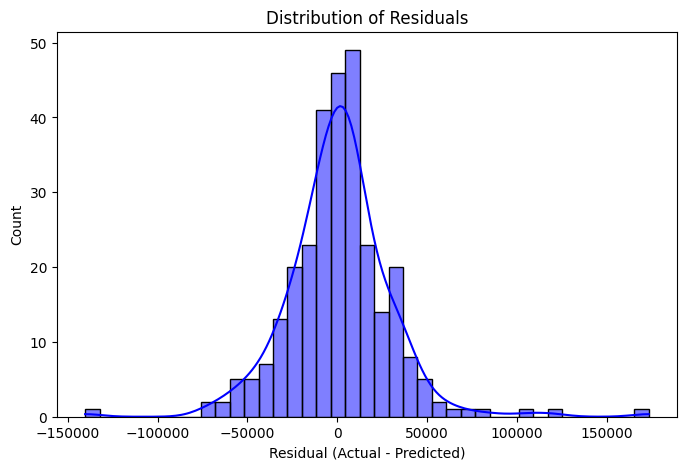

In [8]:
# Distribution of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


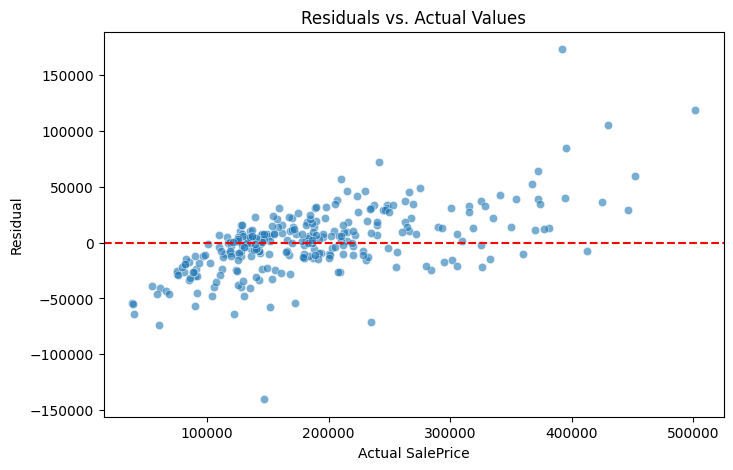

In [9]:
# Residuals vs. Actual
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_dev, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual SalePrice')
plt.ylabel('Residual')
plt.show()


# Load and Predict on Test Dataset

In [10]:
test = pd.read_csv('../data/new_test.csv')
test_ids = test['Id']
test = test[list(X_train.columns)]
y_test_pred = model.predict(test)
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
